In [1]:

!pip install pymc3 --upgrade  # This must be called every first run
!pip install PyAstronomy

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.9.3)


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

import numpy as np
import scipy
import pymc3 as pm

from google.colab import drive
drive.mount('/content/drive')



#  Ballesteros' formula, function for BV given T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##### OPTIONS #####

map = 1       # 1 - use find map, 0 - sample 
samples = 500  #if sampling, this is the number that decides the sampling and tuning
tune = 1000

opt_params = 0   # if 1 use predetermined values

errorbars = 0   # plot error bars on surface plot 
smp_rt = 1      # every nth point of true data
num_gen =30 # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)
#!pip install pymc3 --upgrade  # This must be called every first run

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
Mass = data[:, 3][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()
BV =  b.bv2T(np.array(Teff))


In [4]:
'''b = pyasl.BallesterosBV_T()'''


'b = pyasl.BallesterosBV_T()'

# Age 

[7.00936097 0.75939142]


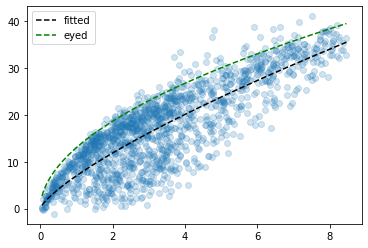

In [5]:
limit = (np.where(np.logical_and(Mass>0.8, Mass<=1)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]


plt.scatter(Age, Prot, alpha=0.2)



coefs = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Age,  Prot, p0=(10,0.5))
print(coefs[0])

x = np.linspace(np.amin(Age),np.amax(Age),1000)
y1 = coefs[0][0]* x **coefs[0][1]
y2 = 13*x**0.52
plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.plot(x,y2, color='g', linestyle='--', label='eyed')
plt.legend()

Fitted the Age vs Prot using a function form of $P \propto aT^b$
Fitting numerically I deteremind $a= 7.01, b = 0.75$
However, fitting by eye and incorpoating prior knowledge, I determined values of $a = 13, b = 0.52$

1.5386192367206752
1.5386192367206752
[1.50181902 0.17202907 1.5384887 ]


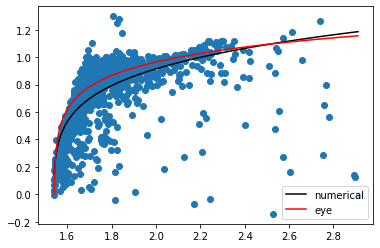

In [6]:

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
Mass = data[:, 3][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()
BV =  b.bv2T(np.array(Teff))


limit = (np.where(np.logical_and(Mass>=0, Mass<=2)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]
BV_short = BV[limit]
print(min(BV))

#coefs = np.polyfit(T, np.log(P), deg=1)
#coefs = scipy.optimize.curve_fit(lambda t,a,c: a*t + c,  Teff_short,   np.log(Prot_short), p0=(1, 3))
#print(coefs[0])

plt.scatter(BV_short, Prot_short/(13*np.power(Age_short, 0.52)))
x = np.linspace(0, max(BV), 1000)
a = 8.8
b = 0.02
d = 7.7

offset = 1.54
print(min(BV))
coefs, _ = scipy.optimize.curve_fit(lambda t,a,b,c: -0.4 + a*np.power(t-c, b),  BV_short,  Prot_short/(13*np.power(Age_short, 0.52)), p0=(1, 0.6, 1.4))
print(coefs)
y = -0.4 + coefs[0]*np.power(x-coefs[2], coefs[1])
y2 = -d+  a*np.power(x-offset, b)
plt.plot(x,y, 'k',label='numerical')
plt.plot(x,y2,'r',label='eye')
plt.legend()


To fit a functional form of BV, I made a plot of $P$ against $ aT^b$ wherea and b are the fitted values from the above cell. I then fit BV with somthing of the form $\frac{P}{aT^b} = d(B-V-f)^g$
<br><br>
This gave me params of <br>
$d = 1.5 \\
f = 1.5 \\
g = 0.17 
$
<br>
these parameters are quite different to what Barnes determined. But Im gonna roll with them
Therefore I have an equation for  P which is something like <br>
$P = AT^b(B-V-f)^g$
where <br>
$A = d \times a = 19.5\\
b = 0.52\\
f = 1.5\\
g = 0.17$


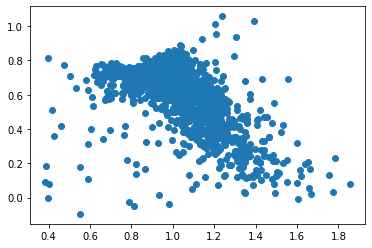

In [7]:
limit = (np.where(np.logical_and(Age>=0, Age<=70)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]
BV_short = BV[limit]
P = Prot_short / (19.5*np.power(Age_short, 0.52)* np.power(BV_short - 1.5, 0.17))
plt.scatter(Mass_short, P)

x = np.arange(min(Mass), max(Mass)) 



In [8]:

### temp: A,B ,C
# Age: D * T ^0.5ish

Xs = np.array([BV, Age, Mass]).T
Y = Prot

A  =19.5
b = 0.52
f = 1.5
g = 0.17


with pm.Model() as model:

    mean = A * Age**b*(BV - f)**g

    l1 = pm.Normal('l1', mu=100, sigma=400)  # 1
    l2 = pm.Normal('l2', mu=3, sigma=3)  #0.2

    resid = Prot - mean

    l = [l1, l2]

    sf2 = pm.Normal("sf2", mu=16, sigma=12)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=Xs, y=resid, noise=sn2)

    if map:
        mp = pm.find_MAP() 
        print(mp)


/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:93: UserWarning: Only 2 column(s) out of 3 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.



{'l1': array(0.28757053), 'l2': array(5.1625721), 'sf2': array(12.83131218), 'sn2_log__': array(0.76235937), 'sn2': array(2.14332716)}


In [ ]:
Xnew1 = np.linspace(np.amin(BV), np.amax(BV), num_gen)
Xnew2 = np.linspace(np.amin(Age), np.amax(Age), num_gen)
Xnew3 = np.linspace(np.amin(Mass), np.amax(Mass), num_gen )

Xnew1, Xnew2, Xnew3 = np.meshgrid(Xnew1, Xnew2, Xnew3)

Xnew = np.stack((Xnew1, Xnew2)).T
Xnew_pred = Xnew.reshape(num_gen**3, 2)

mu, var = gp.predict(Xnew_pred, point=mp, diag=True, pred_noise=True)
sd = np.sqrt(var)

mu = mu.reshape(num_gen, num_gen).T

sd = sd.reshape(num_gen, num_gen).T

/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:93: UserWarning: Only 2 column(s) out of 3 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)


In [ ]:

#mean = mp['A*np.exp(B*(Xnew1 - C))*Xnew2**mp['D']
mean = A * Xnew2*mp['b']*(Xnew1 - f)**mp['g']


fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot_surface(Xnew1, Xnew2,  mean + mu , alpha=0.5, cmap=cm.jet, linewidth=0.1)

ax1.set_xlabel("Age (Gyrs)")
ax1.set_ylabel("BV")
ax1.set_zlabel('Rotation Period (Days)')


ax1.scatter(BV, Age, Y, color='k')



# axis labels and title

plt.title("Posterior distribution")
plt.legend()
ax1.view_init(10, 50)
ax1.invert_yaxis()
plt.show()

print(mu)

In [ ]:
numElems = len(Y)
idx = np.round(np.linspace(0, len(mu.reshape(num_gen**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data


y_pred = mu + mean
mu_test = (y_pred.reshape(num_gen**2)[idx])
sd_test = (sd.reshape(num_gen**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)
# sorts them together :) 

fig = plt.figure(figsize=(16, 12))

plt.plot([min(Y), max(Y)], [min(Y), max(Y)], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Y), vals[0, :], yerr=vals[1, :], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()
